# Notebook 04: Build Knowledge Graph from Extracted Class Relationships

This notebook builds a knowledge graph from UML class diagrams by detecting arrows and matching them to class boxes.

## Pipeline
```
OCR Results (Classes) + YOLO (Arrows) → Arrow-Class Matching → NetworkX Graph → Export
```

## Stages
1. Load OCR extraction results from Notebook 03
2. Load trained YOLO model for arrow detection
3. Detect arrows in each image
4. Match arrows to source/target classes
5. Build NetworkX knowledge graph
6. Visualize graph overlays
7. Export to JSON and GraphML

## 1. Setup & Imports

In [1]:
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Any

import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ultralytics import YOLO

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.graph import (
    UMLKnowledgeGraphBuilder,
    detect_arrows,
    match_arrows_to_classes,
    estimate_arrow_endpoints,
    export_to_json,
    export_to_graphml,
    export_statistics,
    export_by_image,
    load_from_json
)

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/aidensmith/Desktop/CSC581-uml-query-tool


In [2]:
# Configuration
MODEL_PATH = PROJECT_ROOT / "runs" / "detect" / "uml-yolov8s" / "weights" / "best.pt"
OCR_RESULTS_PATH = PROJECT_ROOT / "data" / "processed" / "ocr_results" / "ocr_extraction_results.json"
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "knowledge_graph"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Arrow detection parameters
ARROW_CONFIDENCE = 0.3  # Lower threshold since arrow detection has low mAP
MAX_MATCH_DISTANCE = 100.0  # Maximum distance for arrow-class matching

# Class IDs from YOLO model
ARROW_ID = 0
CLASS_BOX_ID = 1

print(f"Model path: {MODEL_PATH}")
print(f"Model exists: {MODEL_PATH.exists()}")
print(f"OCR results path: {OCR_RESULTS_PATH}")
print(f"OCR results exists: {OCR_RESULTS_PATH.exists()}")

Model path: /Users/aidensmith/Desktop/CSC581-uml-query-tool/runs/detect/uml-yolov8s/weights/best.pt
Model exists: True
OCR results path: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/ocr_results/ocr_extraction_results.json
OCR results exists: True


## 2. Load Data

In [3]:
# Load OCR extraction results from Notebook 03
with open(OCR_RESULTS_PATH, 'r') as f:
    ocr_results = json.load(f)

print(f"Loaded {len(ocr_results)} images from OCR results")

# Summary statistics
total_classes = sum(r['num_classes_detected'] for r in ocr_results)
print(f"Total classes detected: {total_classes}")
print(f"Average classes per image: {total_classes / len(ocr_results):.1f}")

# Show sample
print(f"\nSample image: {Path(ocr_results[0]['image_path']).name}")
print(f"  Classes: {ocr_results[0]['num_classes_detected']}")

Loaded 10 images from OCR results
Total classes detected: 163
Average classes per image: 16.3

Sample image: 73_jpeg.rf.a5fe28bd0fe44445e4fb6ea0af387f78.jpg
  Classes: 25


In [4]:
# Load YOLO model for arrow detection
print("Loading YOLO model...")
detector = YOLO(str(MODEL_PATH))
print("YOLO model loaded successfully!")

Loading YOLO model...
YOLO model loaded successfully!


## 3. Arrow Detection Pipeline

Test arrow detection on a sample image before batch processing.

In [5]:
# Test arrow detection on first image
test_result = ocr_results[0]
test_image_path = test_result['image_path']
test_classes = test_result['classes']

print(f"Testing on: {Path(test_image_path).name}")
print(f"Classes in image: {len(test_classes)}")

# Load image and detect arrows
image = cv2.imread(test_image_path)
if image is not None:
    arrows = detect_arrows(detector, image, confidence_threshold=ARROW_CONFIDENCE)
    print(f"Arrows detected: {len(arrows)}")
    
    # Show arrow details
    for i, arrow in enumerate(arrows[:5]):  # Show first 5
        bbox = arrow['bbox']
        print(f"  Arrow {i+1}: bbox=({bbox['x1']}, {bbox['y1']}) - ({bbox['x2']}, {bbox['y2']}), conf={arrow['confidence']:.2f}")
else:
    print(f"Could not load image: {test_image_path}")

Testing on: 73_jpeg.rf.a5fe28bd0fe44445e4fb6ea0af387f78.jpg
Classes in image: 25
Arrows detected: 18
  Arrow 1: bbox=(929, 207) - (1274, 588), conf=0.93
  Arrow 2: bbox=(1437, 202) - (1774, 477), conf=0.92
  Arrow 3: bbox=(372, 359) - (717, 675), conf=0.87
  Arrow 4: bbox=(392, 427) - (781, 681), conf=0.60
  Arrow 5: bbox=(1763, 3) - (2046, 197), conf=0.57


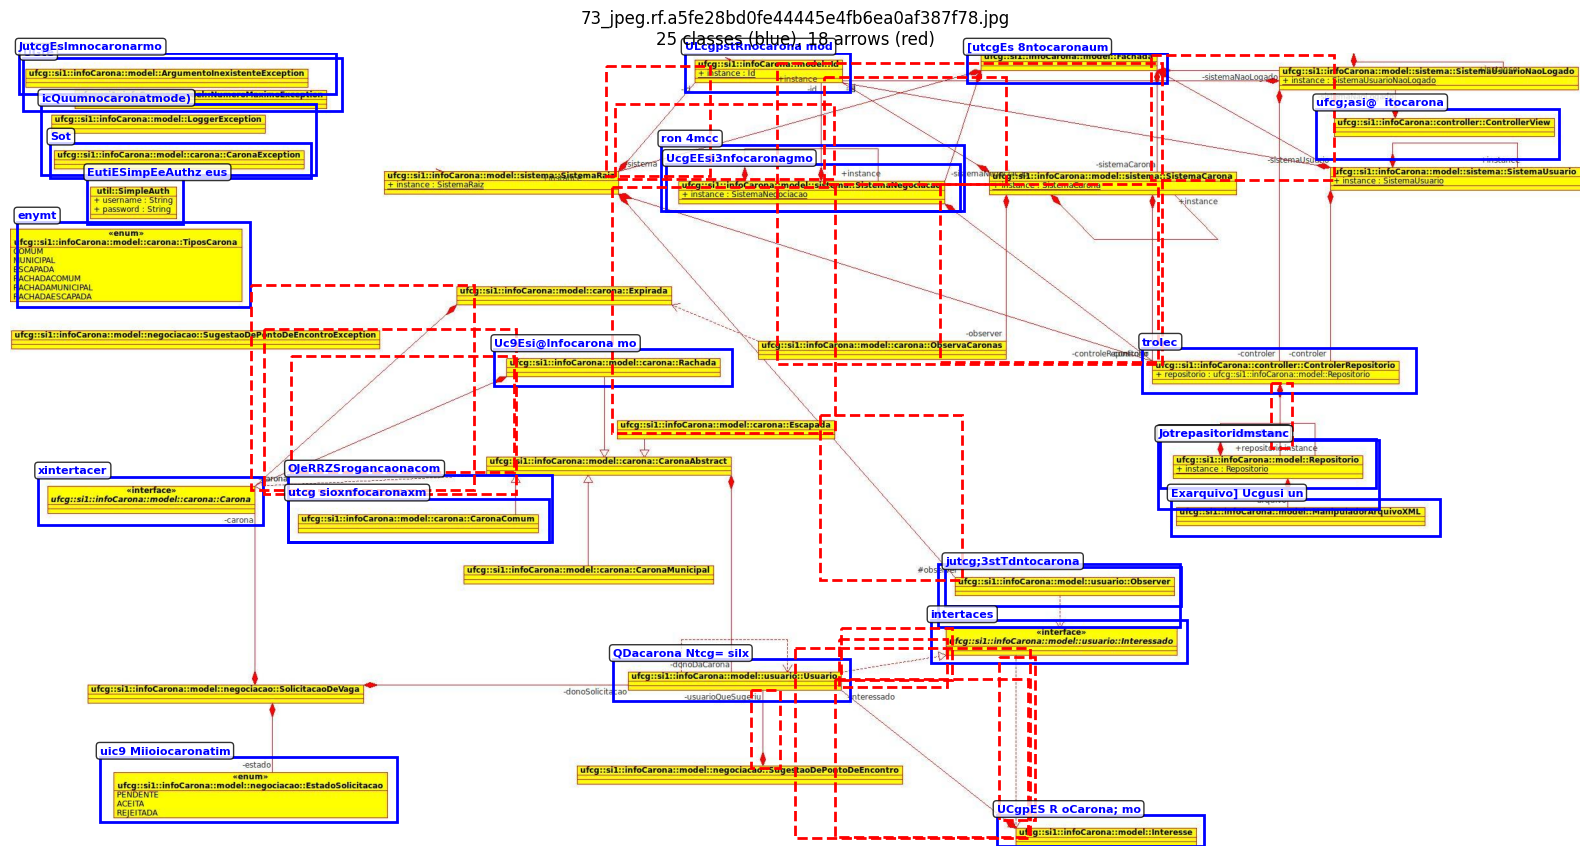

In [6]:
def visualize_detections(image_path: str, classes: List[Dict], arrows: List[Dict], 
                         figsize: Tuple[int, int] = (16, 10)):
    """
    Visualize detected classes and arrows on the image.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image_rgb)
    
    # Draw class boxes in blue
    for cls in classes:
        bbox = cls['bbox']
        rect = plt.Rectangle(
            (bbox['x1'], bbox['y1']),
            bbox['x2'] - bbox['x1'],
            bbox['y2'] - bbox['y1'],
            fill=False, color='blue', linewidth=2
        )
        ax.add_patch(rect)
        ax.text(bbox['x1'], bbox['y1'] - 5, 
                cls.get('class_name', 'Unknown')[:20],
                color='blue', fontsize=8, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Draw arrow boxes in red
    for arrow in arrows:
        bbox = arrow['bbox']
        rect = plt.Rectangle(
            (bbox['x1'], bbox['y1']),
            bbox['x2'] - bbox['x1'],
            bbox['y2'] - bbox['y1'],
            fill=False, color='red', linewidth=2, linestyle='--'
        )
        ax.add_patch(rect)
    
    ax.set_title(f"{Path(image_path).name}\n{len(classes)} classes (blue), {len(arrows)} arrows (red)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize the test image
if image is not None:
    visualize_detections(test_image_path, test_classes, arrows)

## 4. Arrow-to-Class Matching

Match each detected arrow to its source and target classes based on spatial proximity.

In [7]:
# Test arrow-class matching on the sample image
if image is not None and arrows:
    relationships = match_arrows_to_classes(arrows, test_classes, max_distance=MAX_MATCH_DISTANCE)
    
    print(f"Matched {len(relationships)} relationships from {len(arrows)} arrows")
    print(f"\nExtracted relationships:")
    
    for i, rel in enumerate(relationships[:10]):  # Show first 10
        print(f"  {i+1}. {rel['source_class'][:30]} -> {rel['target_class'][:30]}")
        print(f"      type: {rel['relationship_type']}, confidence: {rel['match_confidence']:.2f}")

Matched 8 relationships from 18 arrows

Extracted relationships:
  1. Uc9Esi@lnfocarona modelcaronax -> ron 4mcc
      type: association, confidence: 0.64
  2. QDacarona Ntcg= silxntocarona  -> intertaces
      type: association, confidence: 1.00
  3. ron 4mcc -> ULcgpstRnocarona modeRd ERinst
      type: association, confidence: 0.57
  4. Earepositort instanc -> trolec
      type: inheritance, confidence: 1.00
  5. QDacarona Ntcg= silxntocarona  -> intertaces
      type: association, confidence: 0.96
  6. OJeRRZSrogancaonacomo -> Uc9Esi@lnfocarona modelcaronax
      type: association, confidence: 0.31
  7. UCgpES R oCarona; modelH  nter -> intertaces
      type: inheritance, confidence: 1.00
  8. Uc9Esi@lnfocarona modelcaronax -> [utcgEs 8ntocaronaumodeEFachad
      type: association, confidence: 0.66


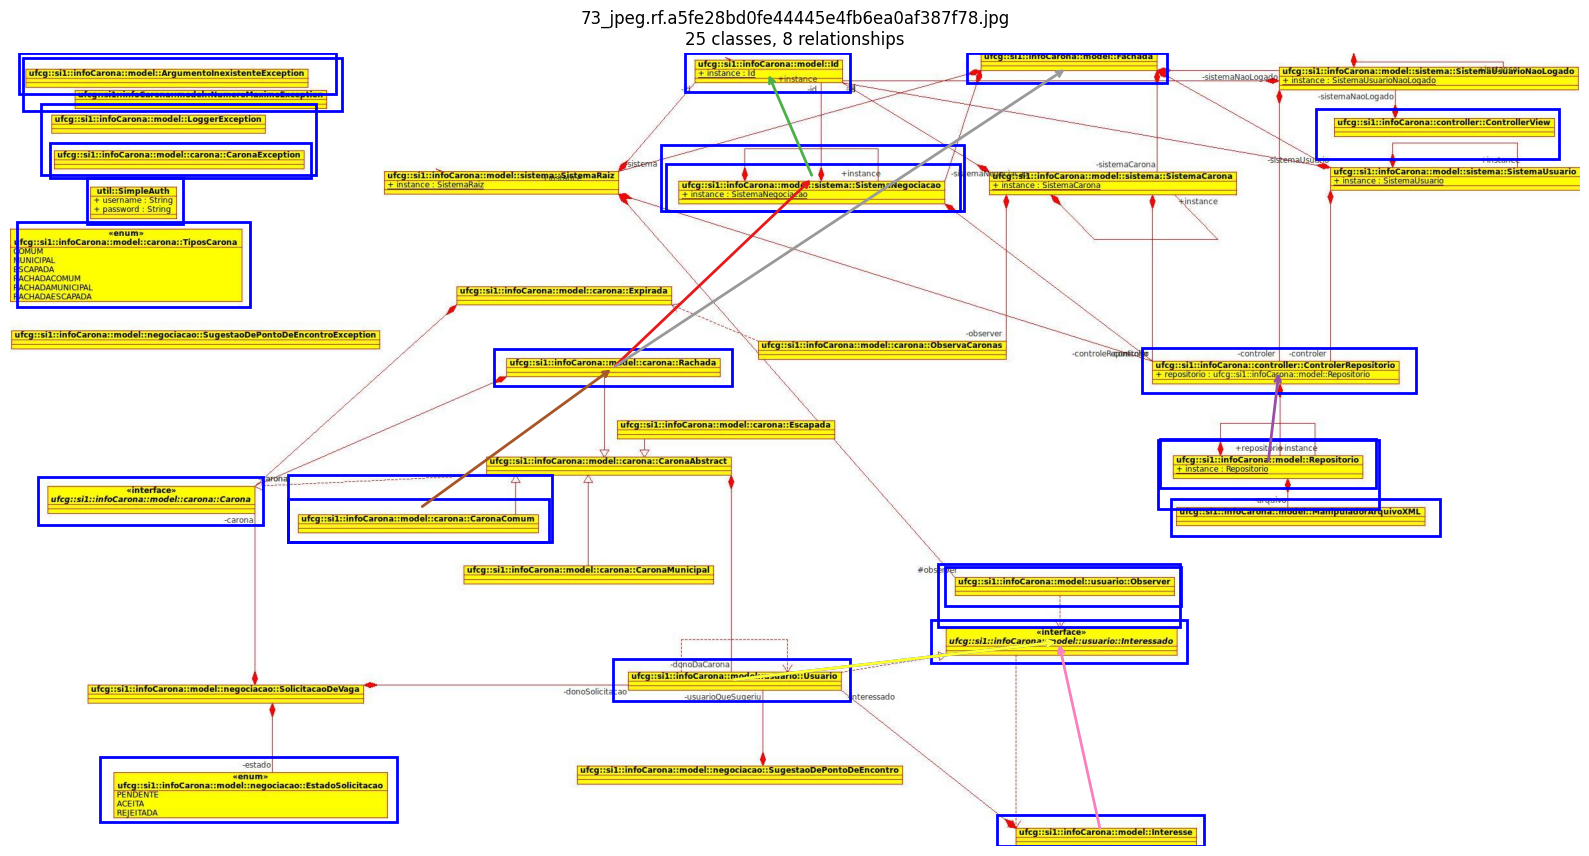

In [8]:
def visualize_relationships(image_path: str, classes: List[Dict], 
                           relationships: List[Dict], figsize: Tuple[int, int] = (16, 10)):
    """
    Visualize detected relationships overlaid on the image.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image_rgb)
    
    # Draw class boxes
    for cls in classes:
        bbox = cls['bbox']
        rect = plt.Rectangle(
            (bbox['x1'], bbox['y1']),
            bbox['x2'] - bbox['x1'],
            bbox['y2'] - bbox['y1'],
            fill=False, color='blue', linewidth=2
        )
        ax.add_patch(rect)
    
    # Draw relationships as arrows between class centers
    colors = plt.cm.Set1(np.linspace(0, 1, max(len(relationships), 1)))
    for i, rel in enumerate(relationships):
        source_bbox = rel['source_bbox']
        target_bbox = rel['target_bbox']
        
        # Calculate centers
        sx = (source_bbox['x1'] + source_bbox['x2']) / 2
        sy = (source_bbox['y1'] + source_bbox['y2']) / 2
        tx = (target_bbox['x1'] + target_bbox['x2']) / 2
        ty = (target_bbox['y1'] + target_bbox['y2']) / 2
        
        # Draw arrow
        color = colors[i % len(colors)]
        ax.annotate('', xy=(tx, ty), xytext=(sx, sy),
                    arrowprops=dict(arrowstyle='->', color=color, lw=2))
    
    ax.set_title(f"{Path(image_path).name}\n{len(classes)} classes, {len(relationships)} relationships")
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize relationships on test image
if image is not None and relationships:
    visualize_relationships(test_image_path, test_classes, relationships)

## 5. Build Knowledge Graph

Use `UMLKnowledgeGraphBuilder` to construct a NetworkX graph from all OCR results.

In [9]:
# Create the graph builder
builder = UMLKnowledgeGraphBuilder(
    model_path=str(MODEL_PATH),
    arrow_confidence=ARROW_CONFIDENCE,
    match_distance=MAX_MATCH_DISTANCE
)

print("UMLKnowledgeGraphBuilder initialized")
print(f"  Arrow confidence threshold: {ARROW_CONFIDENCE}")
print(f"  Max matching distance: {MAX_MATCH_DISTANCE}px")

UMLKnowledgeGraphBuilder initialized
  Arrow confidence threshold: 0.3
  Max matching distance: 100.0px


In [10]:
# Build the knowledge graph from all OCR results
print("Building knowledge graph...\n")
graph = builder.build_from_ocr_results(ocr_results, verbose=True)

Building knowledge graph...

Processing 10/10: 628_jpeg.rf.75da48c78bd90ab8e75de9c0d154c38a.jpg
Built graph with 163 nodes and 53 edges


In [11]:
# Get statistics
stats = builder.get_statistics()

print("Knowledge Graph Statistics")
print("=" * 40)
print(f"Images processed: {stats['images_processed']}")
print(f"Total classes (nodes): {stats['node_count']}")
print(f"Total relationships (edges): {stats['edge_count']}")
print(f"Arrows detected: {stats['total_arrows_detected']}")
print(f"Relationships matched: {stats['total_relationships']}")
print(f"Connected components: {stats.get('connected_components', 'N/A')}")

if 'relationship_types' in stats:
    print(f"\nRelationship types:")
    for rel_type, count in stats['relationship_types'].items():
        print(f"  {rel_type}: {count}")

if 'avg_degree' in stats:
    print(f"\nDegree statistics:")
    print(f"  Average degree: {stats['avg_degree']:.2f}")
    print(f"  Max degree: {stats['max_degree']}")
    print(f"  Isolated nodes: {stats['isolated_nodes']}")

Knowledge Graph Statistics
Images processed: 10
Total classes (nodes): 163
Total relationships (edges): 53
Arrows detected: 130
Relationships matched: 75
Connected components: 110

Relationship types:
  inheritance: 13
  association: 40

Degree statistics:
  Average degree: 0.65
  Max degree: 4
  Isolated nodes: 88


## 6. Graph Visualization

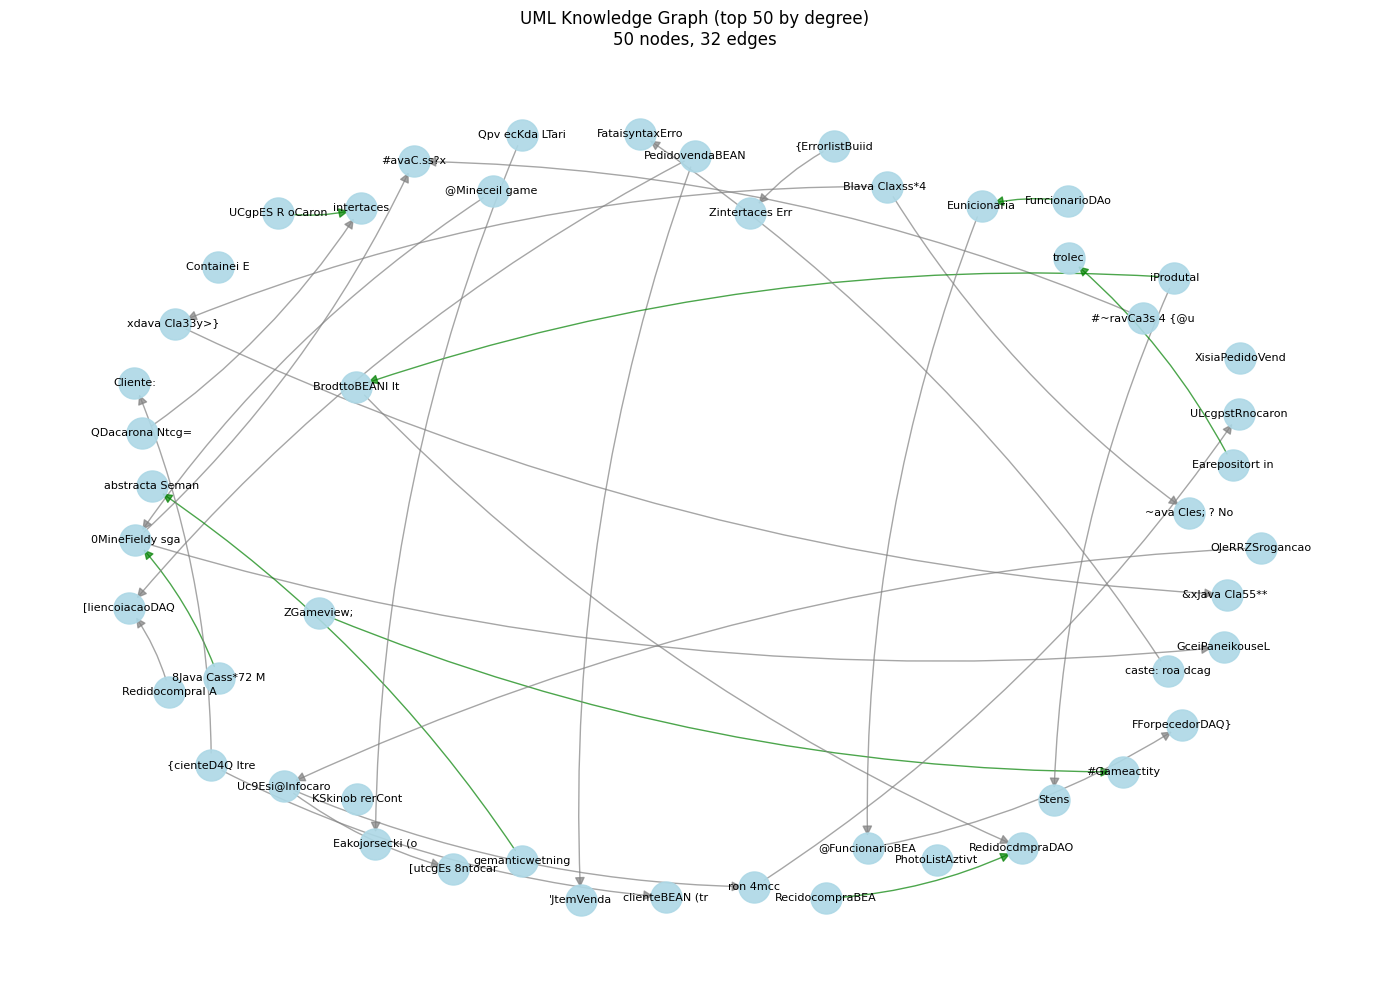

In [12]:
def visualize_networkx_graph(graph: nx.DiGraph, max_nodes: int = 50, 
                             figsize: Tuple[int, int] = (14, 10)):
    """
    Visualize the NetworkX graph using matplotlib.
    """
    # If graph is too large, show a subgraph
    if graph.number_of_nodes() > max_nodes:
        # Get nodes with highest degree
        degrees = dict(graph.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:max_nodes]
        subgraph = graph.subgraph(top_nodes).copy()
        title_suffix = f" (top {max_nodes} by degree)"
    else:
        subgraph = graph
        title_suffix = ""
    
    fig, ax = plt.subplots(1, figsize=figsize)
    
    # Layout
    pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Draw nodes
    node_labels = {n: data.get('name', n)[:15] for n, data in subgraph.nodes(data=True)}
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_color='lightblue', 
                           node_size=500, alpha=0.9)
    nx.draw_networkx_labels(subgraph, pos, labels=node_labels, ax=ax, 
                            font_size=8)
    
    # Draw edges with colors based on relationship type
    edge_colors = []
    for u, v, data in subgraph.edges(data=True):
        rel_type = data.get('relationship_type', 'association')
        if rel_type == 'inheritance':
            edge_colors.append('green')
        else:
            edge_colors.append('gray')
    
    nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color=edge_colors,
                           arrows=True, arrowsize=15, alpha=0.7,
                           connectionstyle='arc3,rad=0.1')
    
    ax.set_title(f"UML Knowledge Graph{title_suffix}\n"
                 f"{subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize the graph
visualize_networkx_graph(graph)

Subgraph for: 73_jpeg.rf.a5fe28bd0fe44445e4fb6ea0af387f78.jpg
  Nodes: 25
  Edges: 7


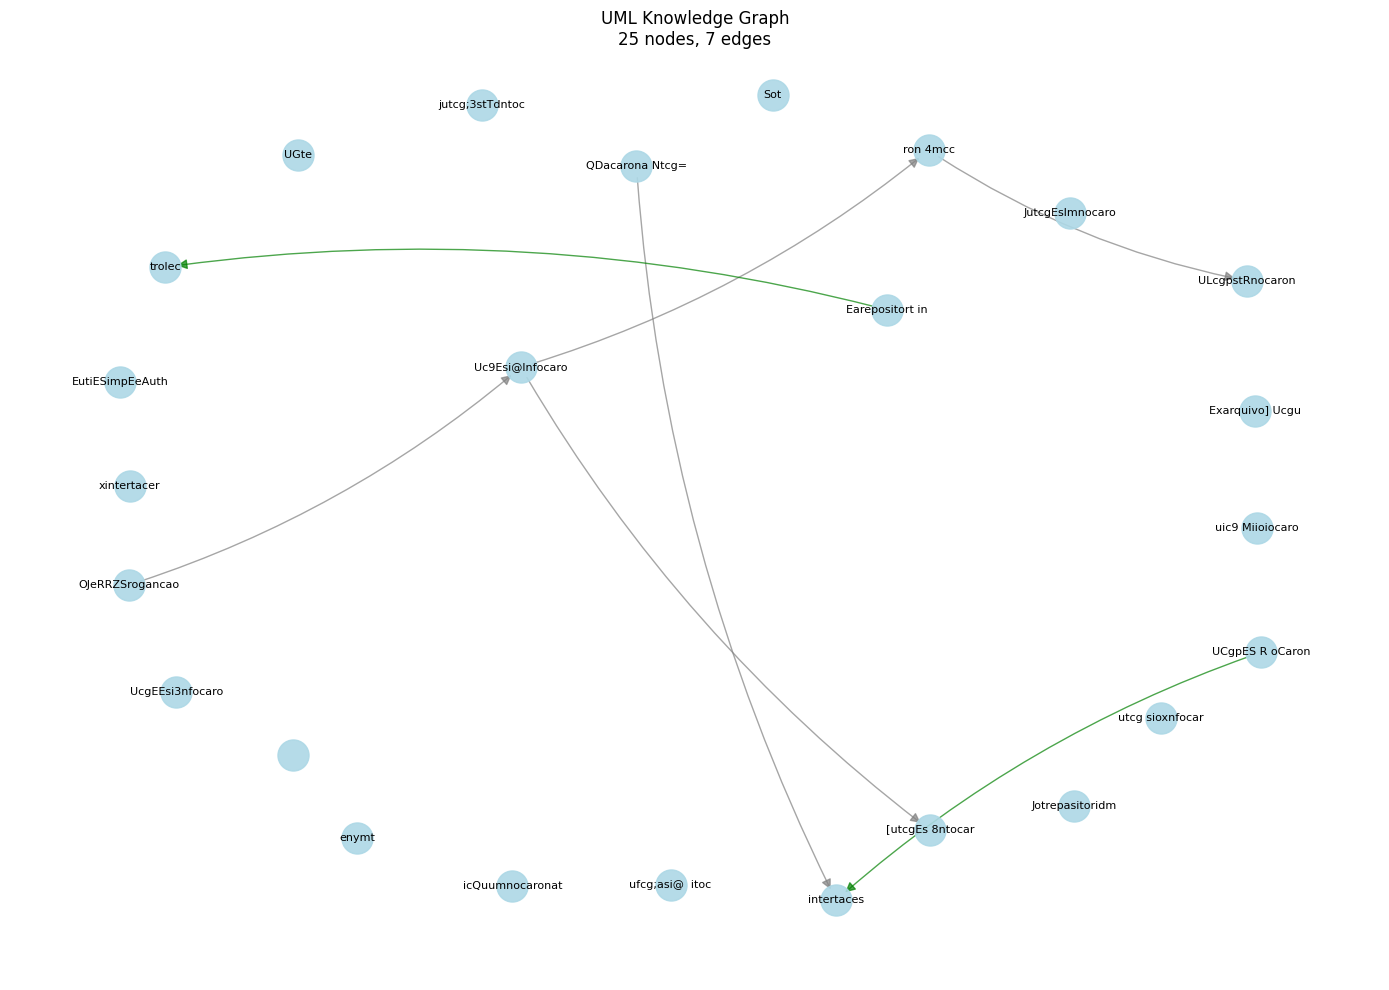

In [13]:
# Show graph for a single image
if ocr_results:
    first_image_path = ocr_results[0]['image_path']
    subgraph = builder.get_subgraph_for_image(first_image_path)
    
    print(f"Subgraph for: {Path(first_image_path).name}")
    print(f"  Nodes: {subgraph.number_of_nodes()}")
    print(f"  Edges: {subgraph.number_of_edges()}")
    
    if subgraph.number_of_nodes() > 0:
        visualize_networkx_graph(subgraph, max_nodes=100)

## 7. Query the Graph

In [14]:
# Find classes by name
def search_classes(graph: nx.DiGraph, name_pattern: str) -> List[str]:
    """Search for classes containing the pattern in their name."""
    matches = []
    pattern = name_pattern.lower()
    for node_id, data in graph.nodes(data=True):
        name = data.get('name', '').lower()
        if pattern in name:
            matches.append((node_id, data.get('name', 'Unknown')))
    return matches


# Example search
matches = search_classes(graph, '')
print(f"Found {len(matches)} classes in the graph")
print("\nSample classes:")
for node_id, name in matches[:10]:
    print(f"  {name}")

Found 163 classes in the graph

Sample classes:
  uic9 Miioiocaronatimodcmneaodac omEstada oSolicitacao PENDENTB
  UCgpES R oCarona; modelH  nteresse
  ULcgpstRnocarona modeRd ERinstanceedld E32r  WhWA3
  
  trolec
  Earepositort instanc
  OJeRRZSrogancaonacomo
  QDacarona Ntcg= silxntocarona modelk:usuario  Usuario-
  utcg sioxnfocaronaxmode) Rcarona: caronacomum
  Jotrepasitoridmstance: gcgu:imnocaronarmodel ERepogitorio tinstancetRepositorio


In [15]:
# Show relationships for a specific class
if matches:
    sample_node = matches[0][0]
    rels = builder.get_relationships_for_class(sample_node)
    
    node_name = graph.nodes[sample_node].get('name', 'Unknown')
    print(f"Relationships for: {node_name}")
    print(f"\nOutgoing ({len(rels['outgoing'])})")
    for rel in rels['outgoing']:
        print(f"  -> {rel['target']} ({rel['relationship_type']})")
    
    print(f"\nIncoming ({len(rels['incoming'])})")
    for rel in rels['incoming']:
        print(f"  <- {rel['source']} ({rel['relationship_type']})")

Relationships for: uic9 Miioiocaronatimodcmneaodac omEstada oSolicitacao PENDENTB

Outgoing (0)

Incoming (0)


## 8. Export Results

In [16]:
# Export to JSON (primary format for Notebook 05)
json_path = OUTPUT_DIR / "knowledge_graph.json"
export_to_json(graph, json_path)

Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/knowledge_graph.json


In [17]:
# Export to GraphML (for external visualization tools)
graphml_path = OUTPUT_DIR / "knowledge_graph.graphml"
export_to_graphml(graph, graphml_path)

Exported GraphML to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/knowledge_graph.graphml


In [18]:
# Export statistics
stats_path = OUTPUT_DIR / "statistics.json"
export_statistics(stats, stats_path)

Exported statistics to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/statistics.json


In [19]:
# Export per-image graphs
per_image_dir = OUTPUT_DIR / "by_image"
export_by_image(graph, per_image_dir)

Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/73_jpeg_rf_a5fe28bd0fe44445e4fb6ea0af387f78_graph.json
Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/160_jpeg_rf_990ad8ebc66ba8ad0ee555345112c51c_graph.json
Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/277_jpeg_rf_a448ab83538f0a27fc95d9433ac73bb8_graph.json
Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/1_jpeg_rf_ad39ffc15a631446036e633fa5918f1d_graph.json
Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/636_jpeg_rf_dfa501633efd056014eaa7751ea8caec_graph.json
Exported graph to: /Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/299_jpeg_rf_a94e6a58ae312156641bff56e5a05fdd_graph.json
Exported graph to: /Users

{'/Users/aidensmith/.cache/kagglehub/datasets/domenicoarm/uml-class-diagram-dataset-bounded-box-rating/versions/2/UML_YOLOv8/test/images/73_jpeg.rf.a5fe28bd0fe44445e4fb6ea0af387f78.jpg': PosixPath('/Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/73_jpeg_rf_a5fe28bd0fe44445e4fb6ea0af387f78_graph.json'),
 '/Users/aidensmith/.cache/kagglehub/datasets/domenicoarm/uml-class-diagram-dataset-bounded-box-rating/versions/2/UML_YOLOv8/test/images/160_jpeg.rf.990ad8ebc66ba8ad0ee555345112c51c.jpg': PosixPath('/Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/160_jpeg_rf_990ad8ebc66ba8ad0ee555345112c51c_graph.json'),
 '/Users/aidensmith/.cache/kagglehub/datasets/domenicoarm/uml-class-diagram-dataset-bounded-box-rating/versions/2/UML_YOLOv8/test/images/277_jpeg.rf.a448ab83538f0a27fc95d9433ac73bb8.jpg': PosixPath('/Users/aidensmith/Desktop/CSC581-uml-query-tool/data/processed/knowledge_graph/by_image/277_jpeg_rf_a448ab83538

In [20]:
# Verify exported JSON
print("Verifying exported files...")

# Load and check JSON
loaded_graph = load_from_json(json_path)
print(f"\nLoaded from JSON:")
print(f"  Nodes: {loaded_graph.number_of_nodes()}")
print(f"  Edges: {loaded_graph.number_of_edges()}")

# Check match with original
assert loaded_graph.number_of_nodes() == graph.number_of_nodes(), "Node count mismatch!"
assert loaded_graph.number_of_edges() == graph.number_of_edges(), "Edge count mismatch!"
print("\nVerification passed!")

Verifying exported files...

Loaded from JSON:
  Nodes: 163
  Edges: 53

Verification passed!


In [21]:
# Preview exported JSON structure
with open(json_path, 'r') as f:
    data = json.load(f)

print("JSON Structure:")
print(f"  metadata: {list(data['metadata'].keys())}")
print(f"  nodes: {len(data['nodes'])} entries")
print(f"  edges: {len(data['edges'])} entries")

if data['nodes']:
    print(f"\nSample node:")
    sample_node = data['nodes'][0]
    print(json.dumps(sample_node, indent=2)[:500] + "...")

if data['edges']:
    print(f"\nSample edge:")
    print(json.dumps(data['edges'][0], indent=2))

JSON Structure:
  metadata: ['created_at', 'node_count', 'edge_count', 'source_images']
  nodes: 163 entries
  edges: 53 entries

Sample node:
{
  "id": "uic9_Miioiocaronatimodcmneaodac_omEstada_oSolicitacao_PENDENTB_84843424",
  "name": "uic9 Miioiocaronatimodcmneaodac omEstada oSolicitacao PENDENTB",
  "type": "class",
  "attributes": [],
  "methods": [],
  "bbox": {
    "x1": 138,
    "y1": 1088,
    "x2": 597,
    "y2": 1188
  },
  "source_image": "/Users/aidensmith/.cache/kagglehub/datasets/domenicoarm/uml-class-diagram-dataset-bounded-box-rating/versions/2/UML_YOLOv8/test/images/73_jpeg.rf.a5fe28bd0fe44445e4fb6ea0af387f78.jpg",
 ...

Sample edge:
{
  "source": "UCgpES_R_oCarona__modelH__nteresse_84843424",
  "target": "intertaces_84843424",
  "relationship_type": "inheritance",
  "arrow_bbox": {
    "x1": 1528,
    "y1": 933,
    "x2": 1583,
    "y2": 1185
  },
  "arrow_confidence": 0.31541576981544495,
  "match_confidence": 1.0,
  "source_image": "/Users/aidensmith/.cache/kaggle

## 9. Summary

This notebook builds a knowledge graph from UML class diagrams:

1. **Arrow Detection**: Uses YOLO model to detect relationship arrows in diagrams
2. **Arrow Matching**: Matches arrows to source/target classes based on spatial proximity
3. **Graph Construction**: Creates NetworkX DiGraph with classes as nodes and relationships as edges
4. **Export**: Saves graph in JSON and GraphML formats

### Outputs
- `knowledge_graph.json` - Combined graph for all images (input for Notebook 05)
- `knowledge_graph.graphml` - GraphML format for Gephi/yEd
- `statistics.json` - Graph statistics
- `by_image/` - Per-image graphs

### Next Steps
- **Notebook 05**: Implement GraphRAG query interface with LLM

In [22]:
# Final summary
print("Knowledge Graph Construction Complete!")
print("=" * 50)
print(f"\nGraph Statistics:")
print(f"  Nodes (classes): {graph.number_of_nodes()}")
print(f"  Edges (relationships): {graph.number_of_edges()}")
print(f"\nOutput files:")
for f in OUTPUT_DIR.glob("*"):
    if f.is_file():
        size = f.stat().st_size / 1024
        print(f"  {f.name}: {size:.1f} KB")
    elif f.is_dir():
        count = len(list(f.glob("*")))
        print(f"  {f.name}/: {count} files")

Knowledge Graph Construction Complete!

Graph Statistics:
  Nodes (classes): 163
  Edges (relationships): 53

Output files:
  knowledge_graph.graphml: 138.0 KB
  statistics.json: 0.4 KB
  by_image/: 10 files
  knowledge_graph.json: 147.1 KB
